In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

REPORT_FILE_PATH = Path('../llm-answer-results/reports')
FIGURE_FILE_PATH = Path('../llm-answer-results/figures/')

from base_evaluator import HUMAN_EVALUATED_ANSWERS_REFERENCE_PATH

sns.set_theme()

/home/rehoumir/.cache/pypoetry/virtualenvs/robojudge-pJLOKXWb-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
validate_file_names = [
    path.name for path in ('../../' / HUMAN_EVALUATED_ANSWERS_REFERENCE_PATH).iterdir()]

len(validate_file_names)

20

In [3]:
gpt_custom_df = pd.read_csv(REPORT_FILE_PATH / '2024-04-03' / 'gpt-custom_llm_auto_score.csv')
gpt_df = pd.read_csv(REPORT_FILE_PATH / '2023-11-25' / 'gpt_llm_auto_score.csv')

In [4]:
gpt_custom_df = gpt_custom_df[gpt_custom_df['file_name'].isin(validate_file_names)]
gpt_df = gpt_df[gpt_df['file_name'].isin(validate_file_names)]

In [5]:
gpt_custom_df.head()

,file_name,question,human_answer,llm_answer,score
0,807.txt,\nCo je to exponenciální časová složitost?\n,\nBohužel není možné odpovědět na základě posk...,"\nOdmítněte odpovědět s vysvětlením, že expone...",1
1,125.txt,\nO co se v této věci vedl spor? (jednou větou)\n,\nŽalobkyně požadavala zaplacení částky za odb...,\nVěc se týkala žaloby na zaplacení faktury za...,4
2,949.txt,\nČeho se týkala smlouva mezi žalobkyní a žalo...,\nSmlouva se týkala dodávky zemního plynu do o...,\nSmlouva se týkala dodávky zemního plynu.,8
3,1898.txt,\nJakými dopravními prostředky cestovala žalov...,\nŽalovaná cestovala autobusem MHD a trolejbus...,\nŽalovaná cestovala vozidlem na lince veřejné...,5
4,1927.txt,\nKolik ústních jednání ve věci proběhlo?\n,"\nVe věci žádné ústní jednání neproběhlo, účas...",\nNa základě původního textu nelze odpovědět n...,1


In [6]:
gpt_custom_df['llm_type'] = 'GPT po finetuningu'
gpt_df['llm_type'] = 'GPT před finetuningem'

merged_df = pd.concat([gpt_custom_df, gpt_df])
merged_df.reset_index(inplace=True, drop=True)

In [7]:
merged_df.groupby('llm_type')['score'].describe()

,count,mean,std,min,25%,50%,75%,max
llm_type,,,,,,,,
GPT po finetuningu,20.0,5.9,3.697795,1.0,2.0,5.0,10.0,10.0
GPT před finetuningem,20.0,6.4,3.704904,1.0,3.5,7.5,10.0,10.0


In [8]:
result_table = merged_df.groupby('llm_type')['score'].describe()
result_table['std'] = result_table['std'].round(2)
result_table['mean'] = result_table['mean'].round(2)
result_table['50%'] = result_table['50%'].round(2)
result_table.rename(columns={'count': 'počet', 'mean': 'průměr', 'std': 'směrodatná odchylka', '50%': 'medián'}, inplace=True)
result_table.index.names = ['Typ LLM']
result_table[['počet', 'průměr', 'směrodatná odchylka', 'medián']].to_csv(FIGURE_FILE_PATH/'finetuning_score_by_type.csv')

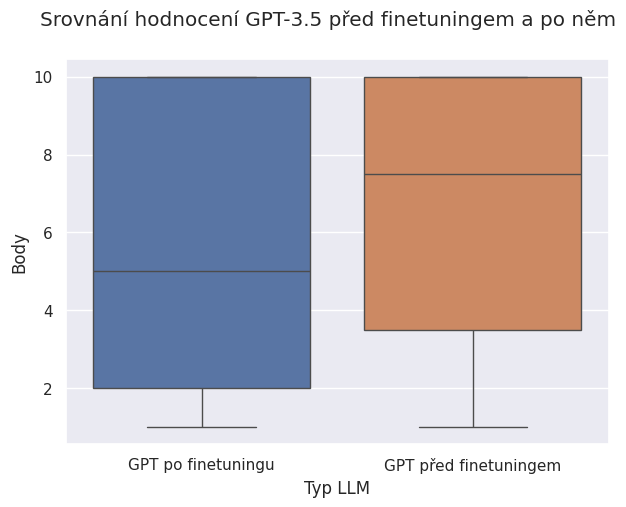

In [9]:
f, ax = plt.subplots(figsize=(7, 5))

f.suptitle('Srovnání hodnocení GPT-3.5 před finetuningem a po něm')
g =sns.boxplot(merged_df, ax=ax, y='score', x='llm_type', hue='llm_type')
ax.set(ylabel='Body', xlabel='Typ LLM')

f.savefig(FIGURE_FILE_PATH / 'finetuning_boxplot.png')

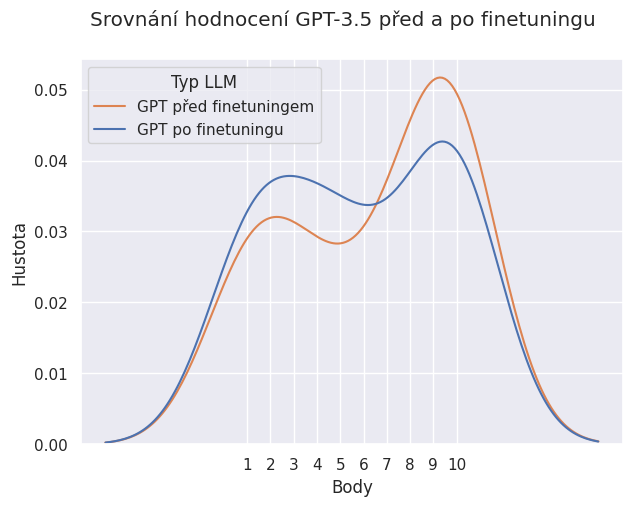

In [10]:
f, ax = plt.subplots(figsize=(7, 5))
# sns.despine(f)

ax.set_xticks(range(1,11))
f.suptitle('Srovnání hodnocení GPT-3.5 před a po finetuningu')
g =sns.kdeplot(merged_df, ax=ax, x='score', hue='llm_type')

ax.set(xlabel='Body', ylabel='Hustota')
ax.legend(title='Typ LLM', labels=['GPT před finetuningem', 'GPT po finetuningu'])

f.savefig(FIGURE_FILE_PATH / 'finetuning_kde.png')

In [11]:
from scipy import stats

stats.wilcoxon(merged_df[merged_df['llm_type'] == 'GPT před finetuningem']
               ['score'], merged_df[merged_df['llm_type'] == 'GPT po finetuningu']['score'])

WilcoxonResult(statistic=67.0, pvalue=0.651776980132799)

In [12]:
training_metrics_df = pd.read_csv(REPORT_FILE_PATH / '2024-04-03' / 'step_metrics.csv')
training_metrics_df.head()

,step,train_loss,train_accuracy,valid_loss,valid_mean_token_accuracy
0,1,1.37134,0.78093,NaN,NaN
1,2,0.92690,0.85885,NaN,NaN
2,3,0.78508,0.87440,NaN,NaN
3,4,0.37405,0.92327,NaN,NaN
4,5,0.54379,0.87059,NaN,NaN


In [13]:
merged_training_metrics_df = training_metrics_df.drop(columns=['valid_mean_token_accuracy', 'train_accuracy']).melt(id_vars=['step'], value_vars=['train_loss', 'valid_loss'], var_name='loss_type')

merged_training_metrics_df['loss_type'].replace({'train_loss': 'Trénovací', 'valid_loss': 'Validační'}, inplace=True)

merged_training_metrics_df.head()

/tmp/ipykernel_10759/1947754394.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_training_metrics_df['loss_type'].replace({'train_loss': 'Trénovací', 'valid_loss': 'Validační'}, inplace=True)


,step,loss_type,value
0,1,Trénovací,1.37134
1,2,Trénovací,0.92690
2,3,Trénovací,0.78508
3,4,Trénovací,0.37405
4,5,Trénovací,0.54379


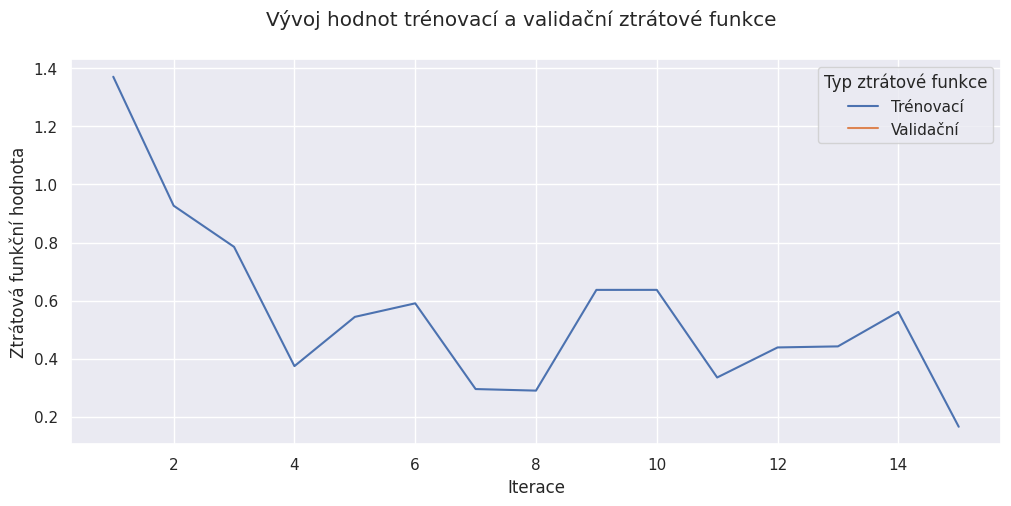

In [14]:
f, ax = plt.subplots(figsize=(12, 5))

f.suptitle('Vývoj hodnot trénovací a validační ztrátové funkce')
g =sns.lineplot(merged_training_metrics_df, ax=ax, y='value', x='step', hue='loss_type')
ax.legend(title='Typ ztrátové funkce')

ax.set(xlabel='Iterace', ylabel='Ztrátová funkční hodnota')

f.savefig(FIGURE_FILE_PATH / 'finetuning_metrics.png')